In [9]:
from scipy.ndimage.filters import convolve
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import cv2
import itertools
import math
from typing import Tuple, List
import canny_edge_detector as canny
from skimage.color import rgb2gray
from PIL import Image
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from log_gabor import normalization_to_template
import scipy.spatial.distance as dist

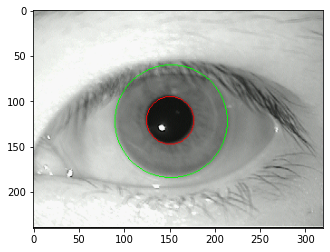

In [10]:
IMG_PATH = 'images/kelvinl1.bmp'
o_circles, inner_circles,imgr = canny.process_for_daugman(canny,IMG_PATH)
inner_radius=inner_circles[0][2], 
outer_radius=o_circles[0][2]
iris_height=outer_radius-inner_radius
iris_height=iris_height[0].astype(int)
inner_radius= inner_radius[0]





In [11]:
def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


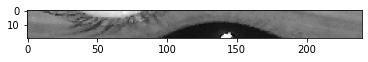

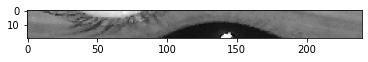

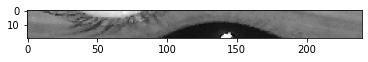

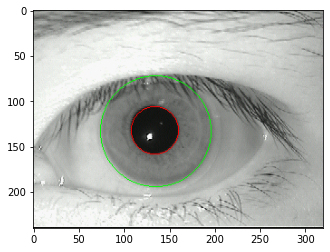

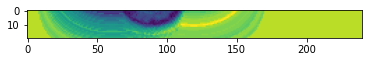

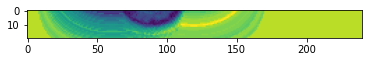

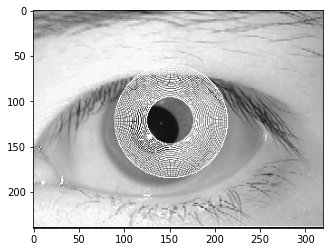

In [12]:
def daugman_normalizaiton(image, height, width, r_in, r_out):
	radiuspixels = 20 + 2
	angledivisions = 240-1
	r = np.arange(radiuspixels)
	theta = np.linspace(0, 2*np.pi, angledivisions+1)

	# Calculate displacement of pupil center from the iris center
	ox = o_circles[0][0] - inner_circles[0][0]
	oy = o_circles[0][1] - inner_circles[0][1]

	if ox <= 0:
		sgn = -1
	elif ox > 0:
		sgn = 1

	if ox==0 and oy > 0:
		sgn = 1

	a = np.ones(angledivisions+1) * (ox**2 + oy**2)

	# Need to do something for ox = 0
	if ox == 0:
		phi = np.pi/2
	else:
		phi = np.arctan(oy/ox)

	b = sgn * np.cos(np.pi - phi - theta)

	# Calculate radius around the iris as a function of the angle
	r = np.sqrt(a)*b + np.sqrt(a*b**2 - (a - inner_radius**2))
	r = np.array([r - outer_radius])

	rmat = np.dot(np.ones([radiuspixels,1]), r)

	rmat = rmat * np.dot(np.ones([angledivisions+1,1]),
							np.array([np.linspace(0,1,radiuspixels)])).transpose()
	rmat = rmat + outer_radius

	# Exclude values at the boundary of the pupil iris border, and the iris scelra border
	# as these may not correspond to areas in the iris region and will introduce noise.
	# ie don't take the outside rings as iris data.
	rmat = rmat[1 : radiuspixels-1, :]

	# Calculate cartesian location of each data point around the circular iris region
	xcosmat = np.dot(np.ones([radiuspixels-2,1]), np.array([np.cos(theta)]))
	xsinmat = np.dot(np.ones([radiuspixels-2,1]), np.array([np.sin(theta)]))

	xo = rmat * xcosmat
	yo = rmat * xsinmat

	xo = o_circles[0][0] + xo
	xo = np.round(xo).astype(int)
	coords = np.where(xo >= image.shape[1])
	xo[coords] = image.shape[1] - 1
	coords = np.where(xo < 0)
	xo[coords] = 0

	yo = o_circles[0][1] - yo
	yo = np.round(yo).astype(int)
	coords = np.where(yo >= image.shape[0])
	yo[coords] = image.shape[0] - 1
	coords = np.where(yo < 0)
	yo[coords] = 0

	# Extract intensity values into the normalised polar representation through
	# interpolation
	# x,y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
	# f = interpolate.interp2d(x, y, image, kind='linear')
	# polar_array = f(xo, yo)
	# polar_array = polar_array / 255

	polar_array = image[yo, xo]
	polar_array = polar_array / 255

	# Create noise array with location of NaNs in polar_array
	polar_noise = np.zeros(polar_array.shape)
	coords = np.where(np.isnan(polar_array))
	polar_noise[coords] = 1

	# Get rid of outling points in order to write out the circular pattern
	image[yo, xo] = 255

	# Get pixel coords for circle around iris
	x,y = circlecoords([inner_circles[0][0],inner_circles[0][1]],inner_radius, image.shape)
	image[y,x] = 255

	# Get pixel coords for circle around pupil
	xp,yp = circlecoords([o_circles[0][0],o_circles[0][1]],outer_radius, image.shape)
	image[yp,xp] = 255

	# Replace NaNs before performing feature encoding
	coords = np.where((np.isnan(polar_array)))
	polar_array2 = polar_array
	polar_array2[coords] = 0.5
	avg = np.sum(polar_array2) / (polar_array.shape[0] * polar_array.shape[1])
	polar_array[coords] = avg
	plt.imshow(polar_array)
	plt.show()
	return polar_array, polar_noise.astype(bool)

def circlecoords(c, r, imgsize, nsides=600):
	"""
	Description:
		Find the coordinates of a circle based on its centre and radius.

	Input:
		c   	- Centre of the circle.
		r  		- Radius of the circle.
		imgsize - Size of the image that the circle will be plotted onto.
		nsides 	- Number of sides of the convex-hull bodering the circle
				  (default as 600).

	Output:
		x,y     - Circle coordinates.
	"""
	a = np.linspace(0, 2*np.pi, 2*nsides+1)
	xd = np.round(r * np.cos(a) + c[0])
	yd = np.round(r * np.sin(a) + c[1])

	#  Get rid of values larger than image
	xd2 = xd
	coords = np.where(xd >= imgsize[1])
	xd2[coords[0]] = imgsize[1] - 1
	coords = np.where(xd < 0)
	xd2[coords[0]] = 0

	yd2 = yd
	coords = np.where(yd >= imgsize[0])
	yd2[coords[0]] = imgsize[0] - 1
	coords = np.where(yd < 0)
	yd2[coords[0]] = 0

	x = np.round(xd2).astype(int)
	y = np.round(yd2).astype(int)
	return x,y
    # thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  # Theta values
    # # print(thetas)
    # # r_out = r_in + r_out
    # # Create empty flatten image
    # flat = np.zeros((height, width, 3), np.uint8)
    # circle_x = int(image.shape[0] / 2)
    # circle_y = int(image.shape[1] / 2)

    # for i in range(width):
    #     for j in range(height):
    #         theta = thetas[i]  # value of theta coordinate
    #         r_pro = j / height  # value of r coordinate(normalized)

    #         # get coordinate of boundaries
    #         Xi = circle_x + r_in * np.cos(theta)
    #         Yi = circle_y + r_in * np.sin(theta)
    #         Xo = circle_x + r_out * np.cos(theta)
    #         Yo = circle_y + r_out * np.sin(theta)

    #         # the matched cartesian coordinates for the polar coordinates
    #         Xc = (1 - r_pro) * Xi + r_pro * Xo
    #         Yc = (1 - r_pro) * Yi + r_pro * Yo

    #         color = image[int(Xc)][int(Yc)]  # color of the pixel

    #         flat[j][i] = color
    # return flat


image = 'images/kelvinl3.bmp'
img = cv2.imread(image, 0)
cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
imgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
plt.imshow(cimg)
image_nor,s = daugman_normalizaiton(cimg, iris_height, 360, inner_radius, outer_radius)
# plt.imshow(image_nor)
# plt.show()
# io.imshow(image_nor)
# showHist(image_nor)

image = 'images/kelvinl1.bmp'
img = cv2.imread(image, 0)
cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

ploar_arr,noise_arr = daugman_normalizaiton(imgr, iris_height, 360, inner_radius, outer_radius)
# temp,mask=normalization_to_template(ploar_arr,noise_arr,1*np.py/4,3)
plt.imshow(ploar_arr)
plt.show()

# temp=temp.flatten()
# mask=mask.flatten()

imageP = 'images/kelvinl3.bmp'
o_circles, inner_circles,imgr0 = canny.process_for_daugman(canny,imageP)
inner_radius=inner_circles[0][2], 
outer_radius=o_circles[0][2]
iris_height=outer_radius-inner_radius
iris_height=iris_height[0].astype(int)
inner_radius= inner_radius[0]


ploar_arr,noise_arr = daugman_normalizaiton(imgr0, iris_height, 360, inner_radius, outer_radius)
# temp2,mask2=normalization_to_template(ploar_arr,noise_arr,1*np.py/4,3)
plt.imshow(ploar_arr)
plt.show()
plt.imshow(imgr)
plt.show()
# temp=temp.flatten()
# mask=mask.flatten()


# temp2=temp2.flatten()
# mask2=mask2.flatten()

# dist.hamming()
# io.imshow(image_nor)
# showHist(image_nor)
# hist = cv2.calcHist([image],[0],None,[256],[0,256])
# plt.imshow(hist)
